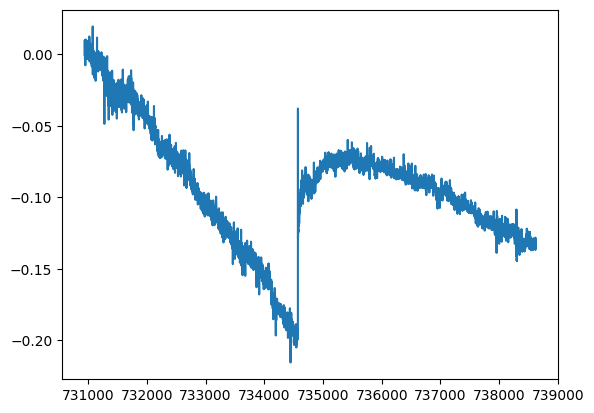

/var/folders/6l/9yq_45597_35nrxp19gw8wb80000gn/T/ipykernel_86954/2674433401.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lt_modelparam = np.linalg.lstsq(wslopemat, pos[i,keep])[0]
/var/folders/6l/9yq_45597_35nrxp19gw8wb80000gn/T/ipykernel_86954/2674433401.py:94: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope[k] = np.linalg.lstsq(timev, position)[0][0]


[0.         0.00010665 0.00013086 0.00014527 0.00015989 0.00016577
 0.00017383 0.00017508]


In [41]:
from matplotlib.transforms import offset_copy
import numpy as np
import h5py as h5py
import math as math
import matplotlib.pyplot as plt

hdf5_file = h5py.File("./test.hdf5", "r")
datef = np.array(hdf5_file.get("date"))
eastposf = np.array(hdf5_file.get("eastpos"))
offset = np.array(hdf5_file.get("offs"))

pos = eastposf

ns = np.size(datef, 0)
nd = np.size(datef, 1)

# datesleft = np.zeros((ns,nd))
# datesright = np.zeros((ns,nd))
# for i in range(0,ns):
#     shiftleft = np.min(np.nonzero(datef[i,:]))
#     shiftright = np.max(np.nonzero(datef[i,:]))

#     datesleft[i] = np.roll(datef[i], - shiftleft)
#     datesright[i] = np.roll(datef[i], - shiftright - 1)

nzdates = datef > 0

offset = np.transpose(offset)
slopes = np.zeros((ns,nd))
for i in range (0,1):
    keep = nzdates[i,:]
    keepdates = datef[i,keep]

    wslopemat = np.transpose(np.array([((keepdates)), (np.ones(sum(keep))), ((np.sin((np.multiply((keepdates),2*math.pi/365.25))))), ((np.cos((np.multiply((keepdates),2*math.pi/365.25))))), ((np.sin((np.multiply((keepdates),2*math.pi/(365.25/2)))))), ((np.cos((np.multiply((keepdates),2*math.pi/(365.25/2)))))), ((np.sin((np.multiply((keepdates),2*math.pi/13.6608))))), ((np.cos((np.multiply((keepdates),2*math.pi/13.6608))))), ((np.sin((np.multiply((keepdates),2*math.pi/14.7653))))), ((np.cos((np.multiply((keepdates),2*math.pi/14.7653))))), ((np.sin((np.multiply((keepdates),2*math.pi/27.5546))))), ((np.cos((np.multiply((keepdates),2*math.pi/27.5546))))), ((np.sin((np.multiply((keepdates),2*math.pi/6793.65))))), ((np.cos((np.multiply((keepdates),2*math.pi/6793.65)))))]))
    
    fig,ax = plt.subplots()
    ax.plot(datef[i,keep], eastposf[i,keep])
    plt.show()

    postseismic = np.zeros((keepdates.shape[0],1))
    eqidx = np.where(keepdates>=734573)
    postseismic[eqidx,0] = .9995 ** (keepdates[eqidx]-734573)

    numoffs = int(max(offset[:,i]))
    offsetcol = offset[keep,i]
    offsetmatrix = np.zeros((len(offsetcol),numoffs))
    for j in range(len(offsetcol)):
        offsetmatrix[j,0] = offsetcol[j]

    for j in range (0,numoffs):
        for k in range(0,len(offsetcol)):
            if offsetmatrix[k,j] > 1:
                offsetmatrix[k,j+1] = offsetmatrix[k,j] - 1
                offsetmatrix[k,j] = 1

    zerocolidx = np.array([])
    for j in range (0, offsetmatrix.shape[1]):
        if np.sum(offsetmatrix[j]) == 0:
            zerocolidx = np.append(zerocolidx, j)
    for j in range(len(zerocolidx), 0):
        offsetmatrix = np.delete(offsetmatrix, zerocolidx[j], axis = 1)

    wslopemat = np.concatenate((wslopemat, offsetmatrix), axis = 1)
    wslopemat = np.hstack((wslopemat, postseismic))
    wslopemat = np.unique(wslopemat, axis = 1) # makes matrix out of order

    # pos = eastposf[i,keep]
    

    lt_modelparam = np.linalg.lstsq(wslopemat, pos[i,keep])[0]
    pred = wslopemat @ lt_modelparam

    # fig,ax = plt.subplots()
    # ax.plot(datef[i, datef[i, :] != 0], eastposf[i, datef[i, :] != 0], '.') # Place time vs. position in those axes for specified station
    # ax.plot(datef[i, datef[i, :] != 0], pred, '.')
    # plt.show()

    pos[i,keep] = pos[i,keep] - pred

    # fig,ax = plt.subplots()
    # ax.plot(datef[i, datef[i, :] != 0], pos, '.')
    # plt.show()

    windowlength = 20
    timev = np.column_stack((np.array(range(0,windowlength + 1)), np.ones(windowlength + 1)))
    slope = np.zeros((windowlength+1))
    for j in range ((windowlength), (len(keepdates) - windowlength)):
    # for j in range (20,21):
        zeropos = 0
        for k in range (0, windowlength + 1):
            position = pos[i, j + (k-windowlength) : j + k + 1]
            nzpos = position != 0
            if np.sum(nzpos) > windowlength/2:
                slope[k] = np.linalg.lstsq(timev, position)[0][0]
        nzslope = slope != 0
        if np.sum(nzslope) > windowlength/2:
            slopes[i,j] = np.mean(slope[np.nonzero(slope)], axis = 0)
print(slopes[0,1837:1845])


